<a href="https://colab.research.google.com/github/stephan-strate/sentiment-fine-foods/blob/master/bert_amazon_fine_food_score_analysis.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!pip install -q ktrain

     |████████████████████████████████| 25.3MB 129kB/s 
     |████████████████████████████████| 983kB 49.1MB/s 
     |████████████████████████████████| 245kB 40.5MB/s 
     |████████████████████████████████| 1.1MB 45.4MB/s 
     |████████████████████████████████| 471kB 47.2MB/s 
     |████████████████████████████████| 890kB 48.0MB/s 
     |████████████████████████████████| 3.0MB 37.0MB/s 
     |████████████████████████████████| 1.1MB 50.7MB/s 


In [ ]:
MODEL_NAME = "distilbert-base-uncased"
BATCH_SIZE = 32
EPOCHS = 2
LEARNING_RATE = 5e-5
MAX_LEN = 128
RANDOM = 42

TU_GREEN = "#639a00"

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

import urllib.request
import zipfile

url = "https://storage.statc.de/datasets/amazon-fine-food/amazon-fine-food.zip"
filehandle, _ = urllib.request.urlretrieve(url)
zip_file_object = zipfile.ZipFile(filehandle, "r")
zip_file_object.extractall()

In [ ]:
df = pd.read_csv("amazon-fine-food-cleaned.csv", delimiter=",", header=0)
print("Dataset has {:,} rows".format(df.shape[0]))

Dataset has 393,670 rows


In [ ]:
import math

def calculate_helpfulness(percentage):
  if math.isnan(percentage):
    return -1
  if percentage > 0.5:
    return 1
  return 0

df["Helpfulness"] = (df["HelpfulnessNumerator"] / df["HelpfulnessDenominator"]).apply(calculate_helpfulness)

In [ ]:
from sklearn.model_selection import train_test_split

train, test = train_test_split(df, test_size=0.3, random_state=42)

print("Train dataset has {:,} rows".format(train.shape[0]))
print("Test dataset has {:,} rows".format(test.shape[0]))

Train dataset has 275,569 rows
Test dataset has 118,101 rows


In [ ]:
import ktrain
from ktrain import text
from pathlib import Path
import random
from os import path
import os.path
import itertools
from sklearn.metrics import confusion_matrix

random.seed(RANDOM)

def train_and_score(X_train, X_test, X_validate, y_train, y_test, y_validate, model_name=None):
  print("train size: {:,}".format(len(X_train)))
  print("test size: {:,}".format(len(X_test)))
  print("validate size: {:,}".format(len(X_validate)))

  model_path = "/content/drive/My Drive/Colab Notebooks/models/{}".format(model_name)
  # check if model was already trained, load model without training
  if path.exists(model_path):
    predictor = ktrain.load_predictor(model_path)
    print(predictor.get_classes())
  else:
    # text transformation configuration
    t = text.Transformer(MODEL_NAME, maxlen=MAX_LEN, class_names=[0, 1, 2, 3, 4])

    # pre-process text (input vectors, truncation, ...)
    trn = t.preprocess_train(X_train, y_train)
    val = t.preprocess_test(X_test, y_test)

    # learn model
    model = t.get_classifier()
    learner = ktrain.get_learner(model, train_data=trn, val_data=val, batch_size=BATCH_SIZE)
    learner.fit(LEARNING_RATE, EPOCHS)

    # save predictor
    predictor = ktrain.get_predictor(learner.model, preproc=t)
    predictor.save(model_path)

  score_path = model_path + "/score"
  if path.exists(score_path):
    score = Path(score_path).read_text()
    predictions = np.load(model_path + "/predictions.npy")
    y_validate = np.load(model_path + "/true_labels.npy")
  else:
    predictions = predictor.predict(X_validate)
    np.save(model_path + "/predictions", predictions)
    np.save(model_path + "/true_labels", y_validate)
    comparison = list(map(lambda x: x[0] == x[1], zip(predictions, y_validate)))
    score = comparison.count(True) / len(y_validate)
    Path(score_path).write_text(str(score))

  print("Validation score: {}".format(score))

  return predictor, score, predictions, y_validate

def train_test_validate_split(X, y, train_size=0.8, sample_size=15000):
  shuffled = random.sample(list(zip(X, y)), len(X))
  validate = shuffled[sample_size:]
  assert len(validate) == len(X) - sample_size
  
  train_test = shuffled[:sample_size]
  assert len(train_test) == sample_size
  train_test_cut = int(train_size * len(train_test))
  train, test = train_test[:train_test_cut], train_test[train_test_cut:]

  X_validate, y_validate = zip(*validate)
  X_train, y_train = zip(*train)
  X_test, y_test = zip(*test)

  return list(X_train), list(X_test), list(X_validate), list(y_train), list(y_test), list(y_validate)

def train_test_validate_split_groups(groups, train_size=0.8, sample_size_group=15000):
  X_train, X_test, X_validate, y_train, y_test, y_validate = zip(*list(map(lambda x: train_test_validate_split(x[1].TextClean.values, x[1].Score.values - 1, sample_size=sample_size_group, train_size=train_size), groups)))
  f = lambda x: list(itertools.chain.from_iterable(x))

  return f(X_train), f(X_test), f(X_validate), f(y_train), f(y_test), f(y_validate)

def confusion_matrix_custom(true_labels, predictions, name=None):
  cm = confusion_matrix(true_labels, predictions, [0, 1, 2, 3, 4], normalize="true")

  fig = plt.figure(figsize=(7, 5))
  ax = fig.add_subplot(111)
  for (i, j), z in np.ndenumerate(cm):
      if i == j:
        ax.text(j, i, "{:0.2f}".format(z), ha="center", va="center", fontsize=12)
  cax = ax.matshow(cm, cmap=plt.cm.Greens, vmin=0, vmax=1)
  fig.colorbar(cax)
  ax.set_xticklabels([''] + [0, 1, 2, 3, 4])
  ax.set_yticklabels([''] + [0, 1, 2, 3, 4])
  plt.xlabel("Predicted")
  plt.ylabel("True")

  plt.savefig(name)
  plt.show()
  return cm

In [ ]:
base_line_predictor, base_line_score, base_line_predictions, base_line_true_labels = train_and_score(*train_test_validate_split(train.TextClean.values, train.Score.values - 1, sample_size=200000), model_name="base_line_real")

train size: 160,000
test size: 40,000
validate size: 75,569
[0, 1, 2, 3, 4]
Validation score: 0.7676031176805304


In [ ]:
base_line_predictions = base_line_predictor.predict(test.TextClean.values)
true_labels = test.Score.values - 1

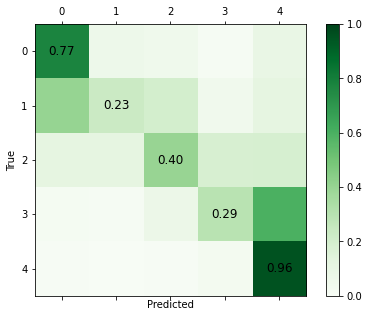

In [ ]:
cm1 = confusion_matrix_custom(true_labels, base_line_predictions, "base_line_matrix.pdf")

In [ ]:
score_groups = train.groupby("Score")
print(score_groups.size())
score_balanced_predictor, score_balanced_score, score_balanced_predictions, score_balanced_true_labels = train_and_score(*train_test_validate_split_groups(score_groups, sample_size_group=12000), model_name="score_balanced_real")

Score
1     25354
2     14643
3     20948
4     39145
5    175479
dtype: int64
train size: 48,000
test size: 12,000
validate size: 215,569
[0, 1, 2, 3, 4]
Validation score: 0.7439752469047034


In [ ]:
score_balanced_predictions = score_balanced_predictor.predict(test.TextClean.values)

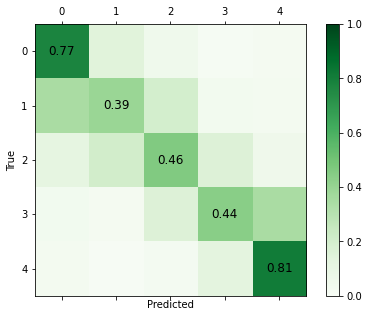

In [ ]:
cm2 = confusion_matrix_custom(true_labels, score_balanced_predictions, "score_balanced_matrix.pdf")

In [ ]:
score_helpfulness_groups = train.groupby(["Score", "Helpfulness"])
print(score_helpfulness_groups.size())
score_helpfulness_balanced_predictor, score_helpfulness_balanced_score, score_helpfulness_balanced_predictions, score_helpfulness_balanced_true_labels = train_and_score(*train_test_validate_split_groups(score_helpfulness_groups, sample_size_group=3500), model_name="score_helpfulness_balanced_real")

Score  Helpfulness
1      -1              6385
        0              9359
        1              9610
2      -1              5302
        0              4242
        1              5099
3      -1              9261
        0              4637
        1              7050
4      -1             20204
        0              4030
        1             14911
5      -1             88220
        0             11342
        1             75917
dtype: int64
train size: 42,000
test size: 10,500
validate size: 223,069
[0, 1, 2, 3, 4]
Validation score: 0.712331162106792


In [ ]:
score_helpfulness_balanced_predictions = score_helpfulness_balanced_predictor.predict(test.TextClean.values)

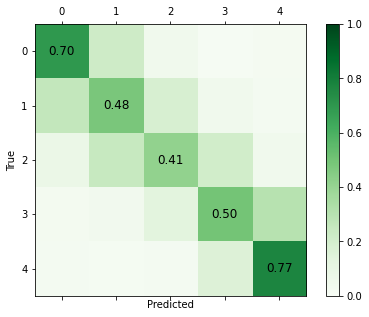

In [ ]:
cm3 = confusion_matrix_custom(true_labels, score_helpfulness_balanced_predictions, "score_helpfulness_balanced_matrix.pdf")

In [ ]:
helpfulness_groups = train.groupby(["Helpfulness"])
print(helpfulness_groups.size())
helpfulness_balanced_predictor, helpfulness_balanced_score, helpfulness_balanced_predictions, helpfulness_balanced_true_labels = train_and_score(*train_test_validate_split_groups(helpfulness_groups, sample_size_group=30000), model_name="helpfulness_balanced_real")

Helpfulness
-1    129372
 0     33610
 1    112587
dtype: int64
train size: 72,000
test size: 18,000
validate size: 185,569
[0, 1, 2, 3, 4]
Validation score: 0.7645350247077907


In [ ]:
helpfulness_balanced_predictions = helpfulness_balanced_predictor.predict(test.TextClean.values)

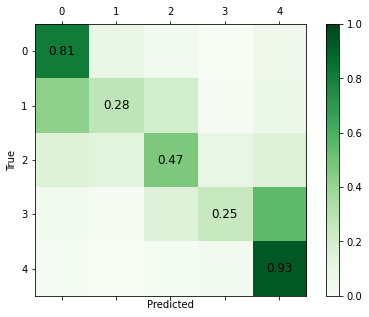

In [ ]:
cm7 = confusion_matrix_custom(true_labels, helpfulness_balanced_predictions, "helpfulness_balanced.pdf")

In [ ]:
only_not_helpful = train[train["Helpfulness"] == 0]
not_helpful_predictor, not_helpful_score, not_helpful_predictions, not_helpful_true_labels = train_and_score(*train_test_validate_split(only_not_helpful.TextClean.values, (only_not_helpful.Score.values - 1), sample_size=30000), model_name="only_not_helpful_real")

train size: 24,000
test size: 6,000
validate size: 3,610
[0, 1, 2, 3, 4]
Validation score: 0.6171745152354571


In [ ]:
not_helpful_predictions = not_helpful_predictor.predict(test.TextClean.values)

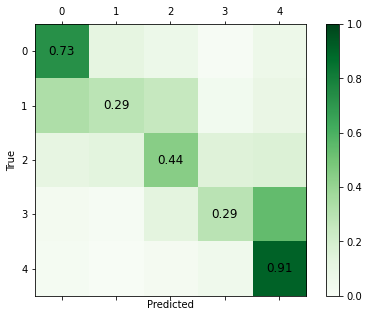

In [ ]:
cm4 = confusion_matrix_custom(true_labels, not_helpful_predictions, "only_not_helpful.pdf")

In [ ]:
only_helpful = train[train["Helpfulness"] == 1]
helpful_predictor, helpful_score, helpful_predictions, helpful_true_labels = train_and_score(*train_test_validate_split(only_helpful.TextClean.values, (only_helpful.Score.values - 1), sample_size=30000), model_name="only_helpful_real")

train size: 24,000
test size: 6,000
validate size: 82,587
[0, 1, 2, 3, 4]
Validation score: 0.7541743857992178


In [ ]:
helpful_predictions = helpful_predictor.predict(test.TextClean.values)

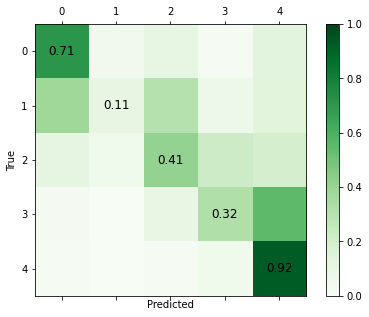

In [ ]:
cm5 = confusion_matrix_custom(true_labels, helpful_predictions, "only_helpful.pdf")

In [ ]:
only_not_rated = train[train["Helpfulness"] == -1]
not_rated_predictor, not_rated_score, not_rated_predictions, not_rated_true_labels = train_and_score(*train_test_validate_split(only_not_rated.TextClean.values, (only_not_rated.Score.values - 1), sample_size=30000), model_name="only_not_rated_real")

train size: 24,000
test size: 6,000
validate size: 99,372
[0, 1, 2, 3, 4]
Validation score: 0.754196353097452


In [ ]:
not_rated_predictions = not_rated_predictor.predict(test.TextClean.values)

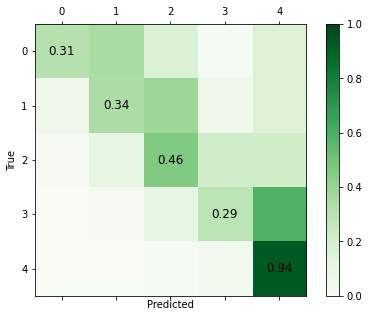

In [ ]:
cm6 = confusion_matrix_custom(true_labels, not_rated_predictions, "only_not_rated.pdf")

In [ ]:
def all_confusion(cms):
  fig, axs = plt.subplots(2, 3, constrained_layout=True, figsize=(15, 11))
  for ax, cm in zip(axs.flat, cms):
    pcm = ax.matshow(cms[cm], cmap=plt.cm.Greens, vmin=0, vmax=1)
    for (i, j), z in np.ndenumerate(cms[cm]):
      if i == j:
        ax.text(j, i, "{:0.2f}".format(z), ha="center", va="center", fontsize=12)
    ax.set_xticklabels([''] + [0, 1, 2, 3, 4])
    ax.set_yticklabels([''] + [0, 1, 2, 3, 4])
    ax.set_xlabel("Predicted")
    ax.set_ylabel("True")
    ax.set_title(cm)

  fig.colorbar(pcm, ax=axs[1:, :], location="bottom", shrink=0.5)
  plt.savefig("all_confusion.pdf")
  plt.show()

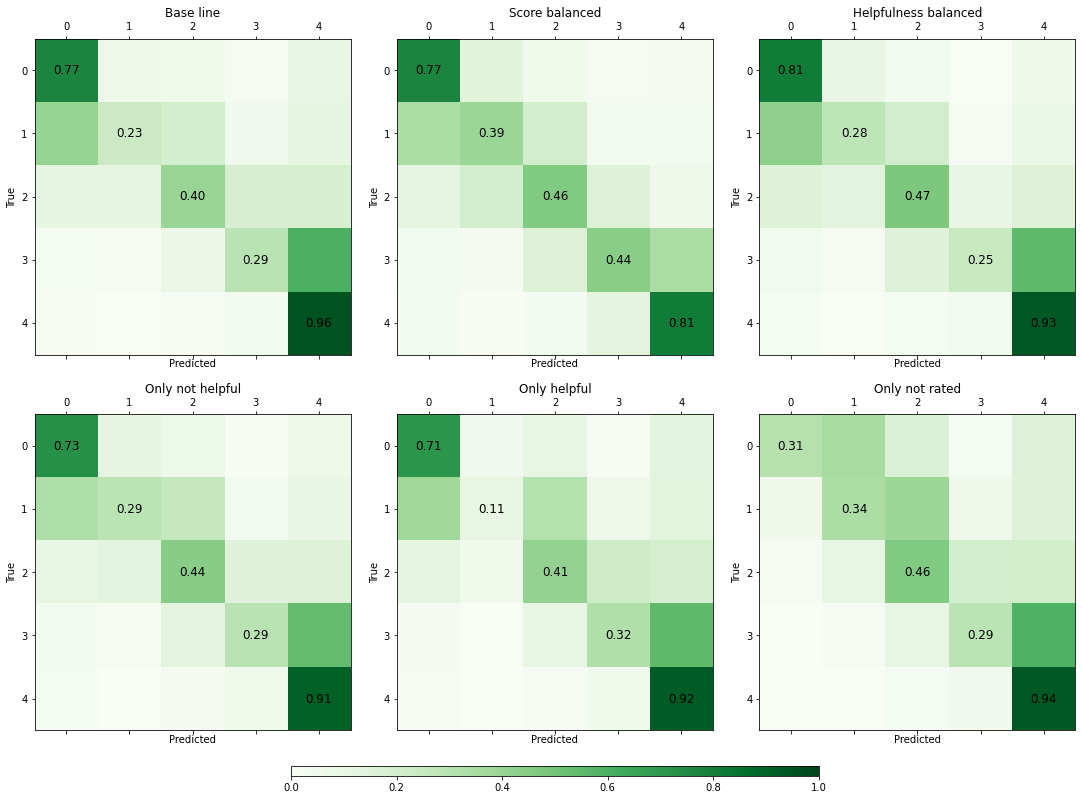

In [ ]:
all_confusion({"Base line": cm1, "Score balanced": cm2, "Helpfulness balanced": cm7, "Only not helpful": cm4, "Only helpful": cm5, "Only not rated": cm6})

In [ ]:
class BertEnsemble():

  def __init__(self, predictors):
    self.predictors = predictors

  def predict(self, X):
    predictions = self.predict_proba(X)
    return np.argmax(predictions, axis=1)

  def predict_proba(self, X):
    predictions_all = [self.predictors[clf][0].predict(X, return_proba=True) * self.predictors[clf][1] for clf in self.predictors]
    return np.sum(predictions_all, axis=0)

In [ ]:
ensemble = BertEnsemble({"base_line": [base_line_predictor, 1.3], "score_balanced": [score_balanced_predictor, 1], "only_not_helpful": [not_helpful_predictor, 0.7]})
predictions = ensemble.predict(test.TextClean.values)
true_labels = test.Score.values - 1

In [ ]:
comparison = list(map(lambda x: x[0] == x[1], zip(predictions, true_labels)))
score = comparison.count(True) / len(true_labels)

In [ ]:
score

0.7658106197237957

In [ ]:
np.save("/content/drive/My Drive/Colab Notebooks/predictions2.npy", predictions)
np.save("/content/drive/My Drive/Colab Notebooks/true_labels2.npy", true_labels)

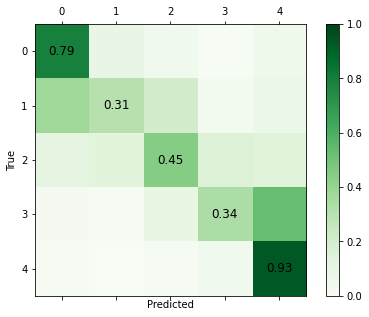

array([[0.79167048, 0.09299771, 0.04686499, 0.00778032, 0.0606865 ],
       [0.37840909, 0.30633117, 0.20275974, 0.03068182, 0.08181818],
       [0.11536718, 0.1362194 , 0.4493427 , 0.1569583 , 0.14211242],
       [0.02268431, 0.00933365, 0.10284735, 0.33731096, 0.52782372],
       [0.01175861, 0.00116922, 0.00892857, 0.04500159, 0.93314201]])

In [ ]:
confusion_matrix_custom(true_labels, predictions, "/content/drive/My Drive/Colab Notebooks/confusion_all.pdf")